### Date	D	CT	FT	IT

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from sklearn.preprocessing import MinMaxScaler

In [3]:
def mape_func(data, target_date):
    group_data = data.groupby(by='Date')
    target_date = data.loc[target_date].index[1]                 #用于mape的时间
    x_pred = data.loc[target_date, 'D'].values.flatten()
    def mapes(x_true,x_pred =x_pred):
        y = x_true['D'].values.flatten()
        x = x_pred
        mape = np.mean(np.abs(x - y)/x)*100
        return mape
       
    mape_data = group_data.apply(mapes)
    #train_index = mape_data[mape_data<10].index
    train_index = mape_data.sort_values()[1:41].index.sort_values()  #无敌
    #train_index = train_index[train_index != target_date]        #让预测数据不会进入模型
    vaild_index = train_index + datetime.timedelta(days=1)
    return train_index,vaild_index


In [4]:
def reshape_data(index_T, index_V, data):
    sc_temp = MinMaxScaler()
    data['CT'] = sc_temp.fit_transform(data['CT'].values.reshape(-1,1))
    data['IT'] = sc_temp.transform(data['IT'].values.reshape(-1,1))
    data['FT'] = sc_temp.transform(data['FT'].values.reshape(-1,1))
    sc_load = MinMaxScaler()
    data['D'] = sc_load.fit_transform(data['D'].values.reshape(-1,1))
    length = int(np.floor(index_T.shape[0]*0.7))
    print(length,'-------------------------------')
    X_train = data.loc[index_T].iloc[:length*24].values.reshape(-1,24,4)      
    y_train = data.loc[index_V].iloc[:length*24, 0].values.reshape(-1,24)    
    X_test = data.loc[index_T].iloc[length*24:].values.reshape(-1,24,4)
    y_test = data.loc[index_V].iloc[length*24:, 0].values.reshape(-1,24)
    
    #X_train, X_test, y_train, y_test = train_test_split(data.loc[index_T], data.loc[index_V, 'load'], test_size=0.3)
    return [X_train, X_test, y_train, y_test, sc_temp, sc_load]


In [5]:
def modle_set():
    #建立LSTM模型 训练
    inputs=tf.keras.layers.Input(shape=(24, 4))
    model=tf.keras.layers.Conv1D(filters = 24, kernel_size = 1, activation = 'sigmoid')(inputs)#卷积层
    model=tf.keras.layers.Conv1D(filters = 24, kernel_size = 1, activation = 'sigmoid')(model)#卷积层
    #model=tf.keras.layers.Conv1D(filters = 48, kernel_size = 1, activation = 'sigmoid')(model)
    #model=tf.keras.layers.MaxPooling1D(pool_size = 48)(model)#池化层
    #model=tf.keras.layers.Dropout(0.03)(model)#droupout层
    #model=tf.keras.layers.GRU(48, activation='tanh', return_sequences=True)(model)
    #model=tf.keras.layers.Dropout(0.03)(model)
    model=tf.keras.layers.LSTM(24, activation='tanh', return_sequences=True)(model)
    #model=tf.keras.layers.LSTM(48, activation='tanh', return_sequences=True)(model)
    #model=tf.keras.layers.Dropout(0.03)(model)
    model=tf.keras.layers.LSTM(24, activation='tanh')(model)
    #model=tf.keras.layers.LSTM(48, activation='tanh')(model)
    outputs = tf.keras.layers.Dense(24)(model)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    model.summary()#展示模型结构
    return model

In [6]:
def mainSet(data, target_date, aim_data):   
    data_real = data.copy()                                                                           #未归一化的datarale
    
    
    train_index,vaild_index = mape_func(data, target_date)
    a = reshape_data(train_index, vaild_index, data)                                                  #会将data     normolization
    
    model = modle_set()
    model.fit(a[0], a[2], epochs = 30, batch_size = 5,shuffle=True,validation_data=(a[1], a[3]))   #训练模型--专属

    for_pred = data.loc[target_date].values.reshape(1,24,4)                                            #用前一天

    pred_data = model.predict(for_pred)                                                                #预测后一天
    pred_data_true = a[-1].inverse_transform(pred_data.reshape(-1,1)).flatten()
    true_value = data_real.loc[aim_data,'D'].values.flatten()                                       #后一天的真实值 
    
    #print(target_date, 'to predict', aim_data)
    
    plt.plot(pred_data_true, 'b')
    plt.plot(true_value,'r')
    plt.show()
    
    #print('pred')
    #print(pred_data_true)
    #print('true')
    #print(true_value)
    mapes = np.mean(np.abs(true_value - pred_data_true)/true_value)*100
    #print('mape:', mapes)
    return pred_data_true, true_value, mapes

In [4]:
data = pd.read_csv('data_model.csv', index_col=['Date'], parse_dates=['Date'])
img = data.D.values

No handles with labels found to put in legend.


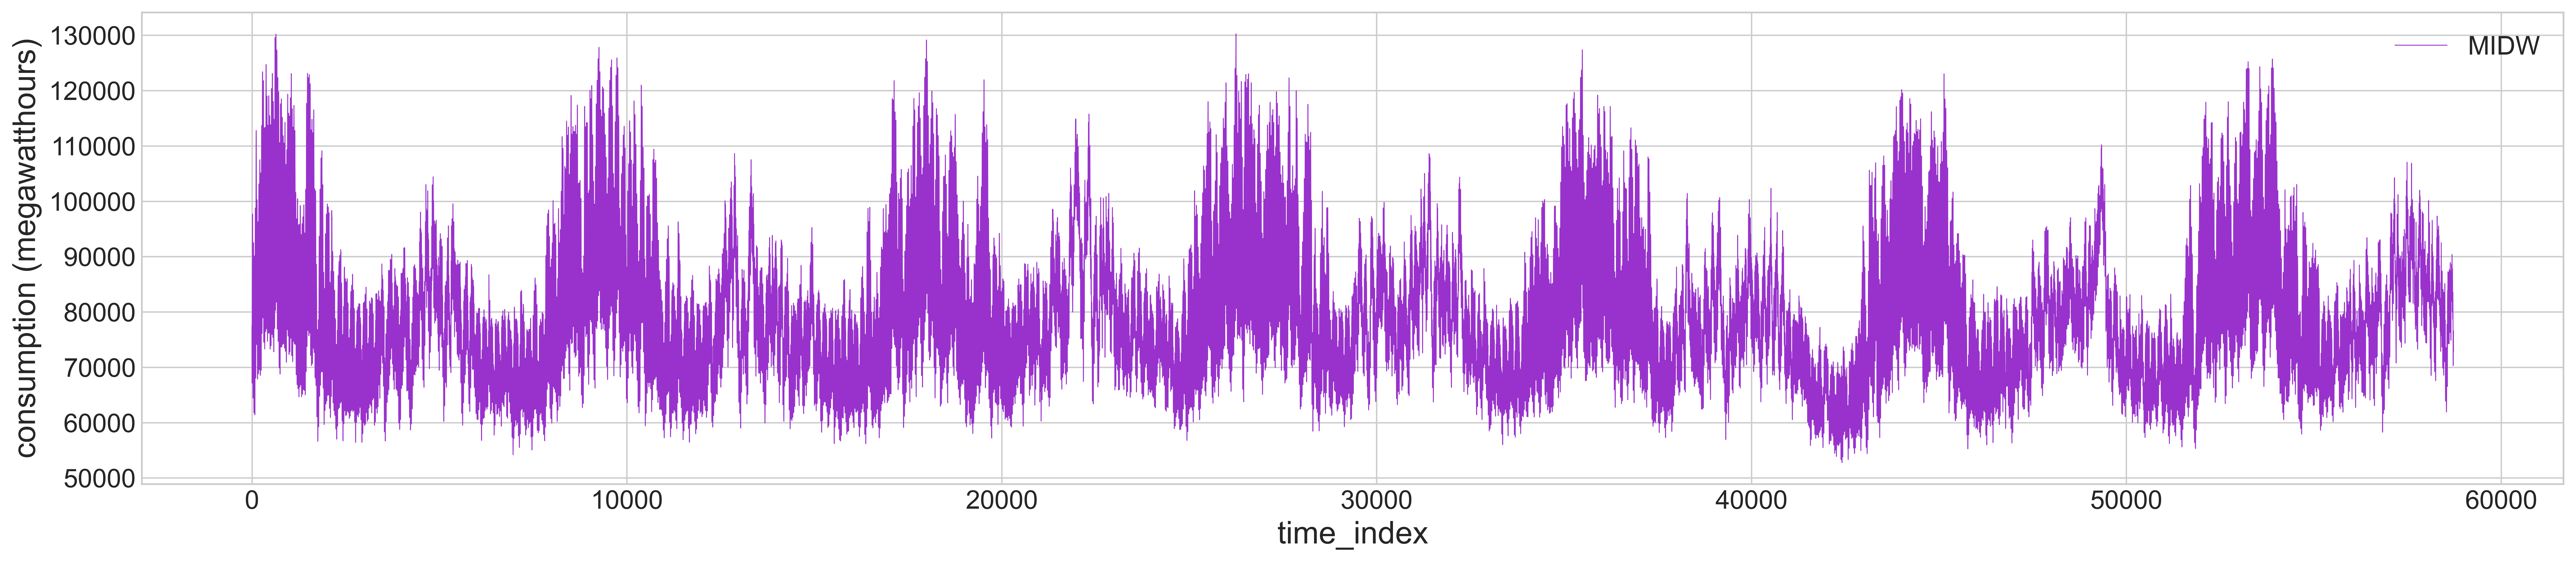

In [6]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(25, 5), dpi=600)
#fig.patch.set_facecolor('red')
ax = fig.add_subplot(1,1,1)
plt.rcParams.update({"font.size":15})
#plt.title("validation_acc",fontsize=13)
plt.legend(loc='lower right', fontsize=40) 
ax.plot(img, 'darkorchid', label='MIDW', linewidth=0.5)
ax.set_xlabel("time_index", fontsize=18)
ax.set_ylabel('consumption (megawatthours)', fontsize=18)
#plt.grid()
plt.legend()
plt.savefig('mid.jpg',dpi=600,bbox_inches = 'tight')

plt.show()

28 -------------------------------
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24, 24)            120       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 24, 24)            600       
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 24)            4704      
_________________________________________________________________
lstm_3 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
____________________

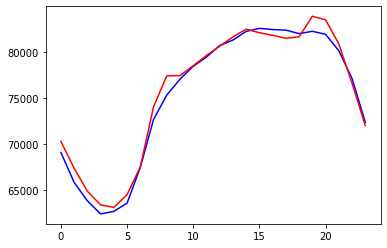

In [9]:
data = pd.read_csv('data_model.csv', index_col=['Date'], parse_dates=['Date'])
pred_data, true_data, mapes = mainSet(data, '2016-11-02', '2016-11-03')

In [28]:
listTarg = []
listAim = []
for i in range(1,29):
    
    if i <10:
       
        #mainSet(data, '2010-12-'+'0'+str(i), '2010-12-'+'0'+str(i+1))
        listTarg.append('2021-05-'+'0'+str(i))
    else:
        #mainSet(data, '2010-12-'+str(i), '2010-12-'+str(i+1))
        listTarg.append('2021-05-'+str(i))

for i in range(2,30):
    if i <10:
       
        #mainSet(data, '2010-12-'+'0'+str(i), '2010-12-'+'0'+str(i+1))
        listAim.append('2021-05-'+'0'+str(i))
    else:
        #mainSet(data, '2010-12-'+str(i), '2010-12-'+str(i+1))
        listAim.append('2021-05-'+str(i))

In [30]:
listTarg, listAim

(['2021-05-01',
  '2021-05-02',
  '2021-05-03',
  '2021-05-04',
  '2021-05-05',
  '2021-05-06',
  '2021-05-07',
  '2021-05-08',
  '2021-05-09',
  '2021-05-10',
  '2021-05-11',
  '2021-05-12',
  '2021-05-13',
  '2021-05-14',
  '2021-05-15',
  '2021-05-16',
  '2021-05-17',
  '2021-05-18',
  '2021-05-19',
  '2021-05-20',
  '2021-05-21',
  '2021-05-22',
  '2021-05-23',
  '2021-05-24',
  '2021-05-25',
  '2021-05-26',
  '2021-05-27',
  '2021-05-28'],
 ['2021-05-02',
  '2021-05-03',
  '2021-05-04',
  '2021-05-05',
  '2021-05-06',
  '2021-05-07',
  '2021-05-08',
  '2021-05-09',
  '2021-05-10',
  '2021-05-11',
  '2021-05-12',
  '2021-05-13',
  '2021-05-14',
  '2021-05-15',
  '2021-05-16',
  '2021-05-17',
  '2021-05-18',
  '2021-05-19',
  '2021-05-20',
  '2021-05-21',
  '2021-05-22',
  '2021-05-23',
  '2021-05-24',
  '2021-05-25',
  '2021-05-26',
  '2021-05-27',
  '2021-05-28',
  '2021-05-29'])

28 -------------------------------
Model: "model_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_118 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_119 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_118 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_119 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_59 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

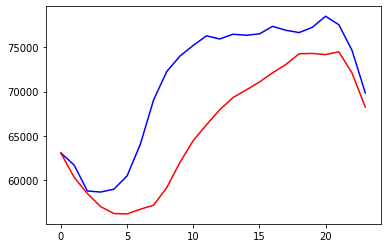

28 -------------------------------
Model: "model_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_120 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_120 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_121 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_60 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

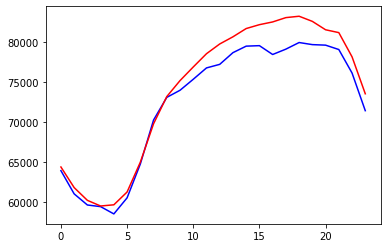

28 -------------------------------
Model: "model_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_122 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_122 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_123 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_61 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

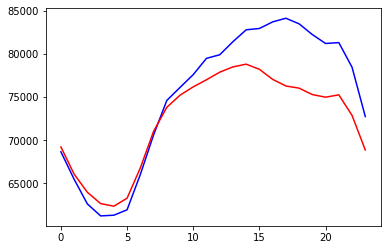

28 -------------------------------
Model: "model_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_124 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_125 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_124 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_125 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_62 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

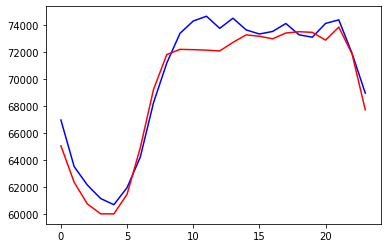

28 -------------------------------
Model: "model_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_126 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_126 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_127 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_63 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

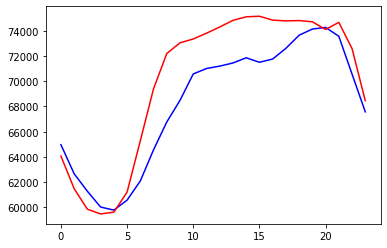

28 -------------------------------
Model: "model_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_128 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_128 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_129 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_64 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

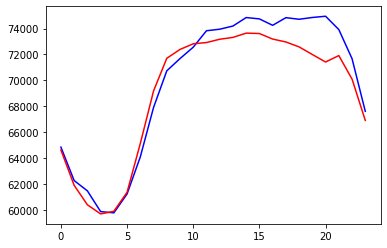

28 -------------------------------
Model: "model_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_130 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_131 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_130 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_131 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_65 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

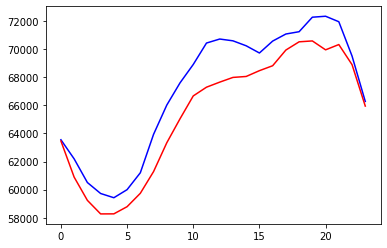

28 -------------------------------
Model: "model_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_132 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_132 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_133 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_66 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

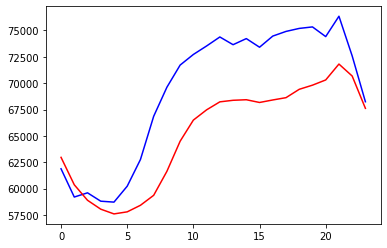

28 -------------------------------
Model: "model_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_134 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_135 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_67 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

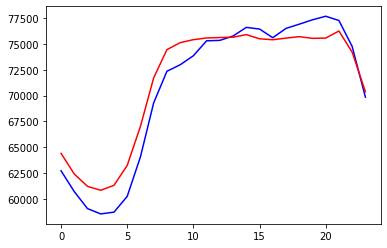

28 -------------------------------
Model: "model_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_69 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_136 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_137 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_136 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_137 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_68 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

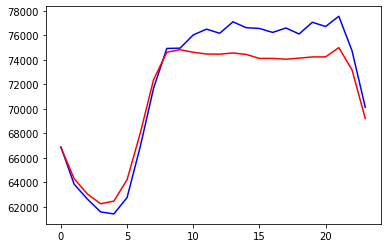

28 -------------------------------
Model: "model_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_138 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_139 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_138 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_139 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_69 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

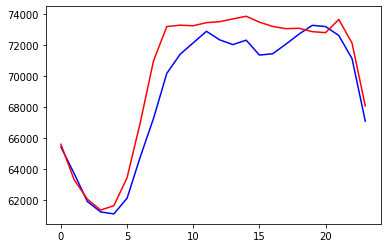

28 -------------------------------
Model: "model_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_140 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_140 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_141 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_70 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

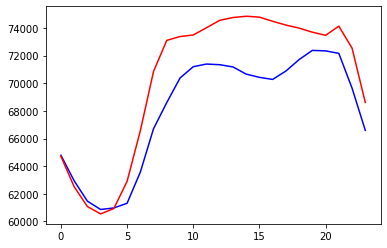

28 -------------------------------
Model: "model_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_72 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_142 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_143 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_142 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_143 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_71 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

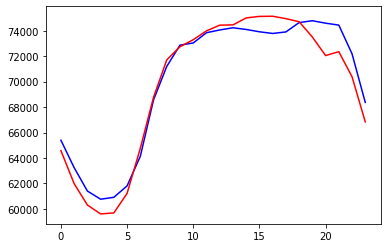

28 -------------------------------
Model: "model_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_73 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_144 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_145 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_144 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_145 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_72 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

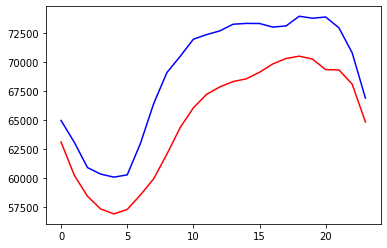

28 -------------------------------
Model: "model_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_146 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_147 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_146 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_147 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_73 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

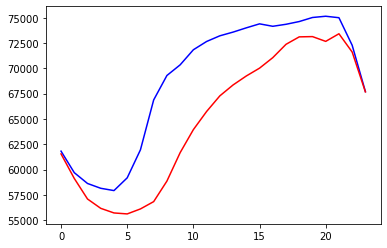

28 -------------------------------
Model: "model_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_148 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_149 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_148 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_149 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_74 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

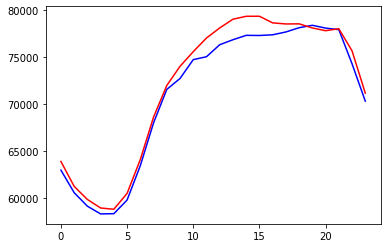

28 -------------------------------
Model: "model_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_76 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_150 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_150 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_151 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_75 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

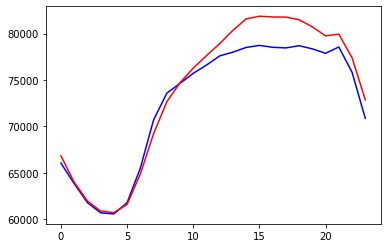

28 -------------------------------
Model: "model_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_77 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_152 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_153 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_152 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_153 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_76 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

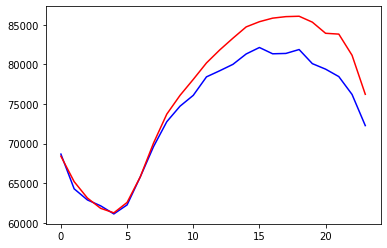

28 -------------------------------
Model: "model_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_78 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_154 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_155 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_154 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_155 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_77 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

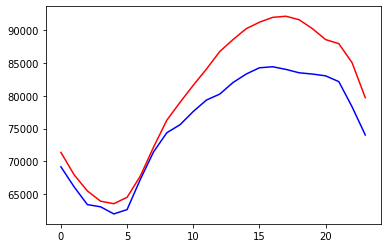

28 -------------------------------
Model: "model_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_79 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_156 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_157 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_156 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_157 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_78 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

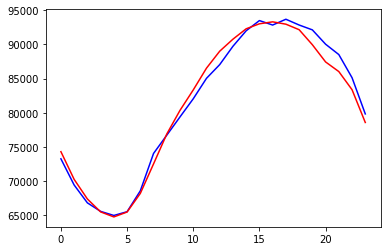

28 -------------------------------
Model: "model_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_80 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_158 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_159 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_158 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_159 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_79 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

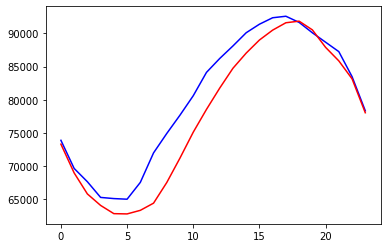

28 -------------------------------
Model: "model_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_81 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_160 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_161 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_160 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_161 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_80 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

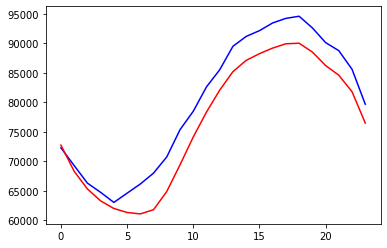

28 -------------------------------
Model: "model_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_82 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_162 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_162 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_163 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_81 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

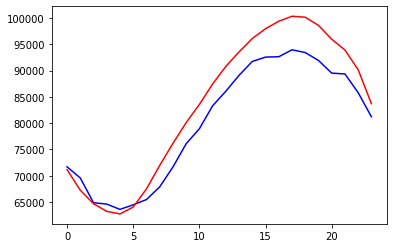

28 -------------------------------
Model: "model_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_83 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_164 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_165 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_164 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_165 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_82 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

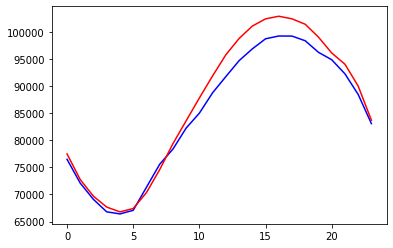

28 -------------------------------
Model: "model_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_84 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_166 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_167 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_166 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_167 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_83 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

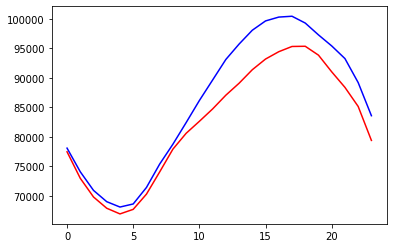

28 -------------------------------
Model: "model_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_85 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_168 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_169 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_168 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_169 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_84 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

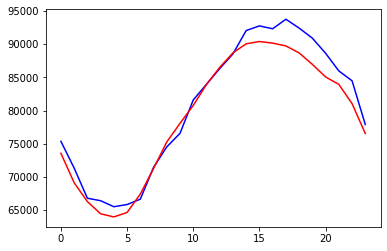

28 -------------------------------
Model: "model_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_86 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_170 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_171 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_170 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_171 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_85 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

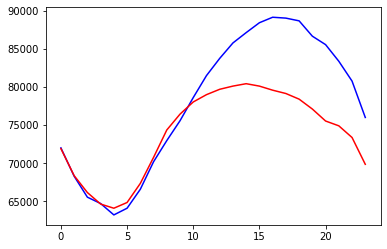

28 -------------------------------
Model: "model_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
conv1d_172 (Conv1D)          (None, 24, 24)            120       
_________________________________________________________________
conv1d_173 (Conv1D)          (None, 24, 24)            600       
_________________________________________________________________
lstm_172 (LSTM)              (None, 24, 24)            4704      
_________________________________________________________________
lstm_173 (LSTM)              (None, 24)                4704      
_________________________________________________________________
dense_86 (Dense)             (None, 24)                600       
Total params: 10,728
Trainable params: 10,728
Non-trainable params: 0
___________________

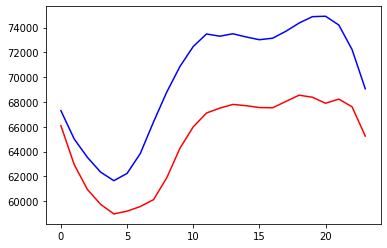

In [31]:
pred = np.array([])
true = np.array([])
mape_values = []
for i, j in zip(listTarg, listAim):
    data = pd.read_csv('data_model.csv', index_col=['Date'], parse_dates=['Date'])
    pred_data_true, true_value, mapes=mainSet(data, i, j)
    pred = np.append(pred, pred_data_true)
    true = np.append(true, true_value)
    mape_values.append(mapes)

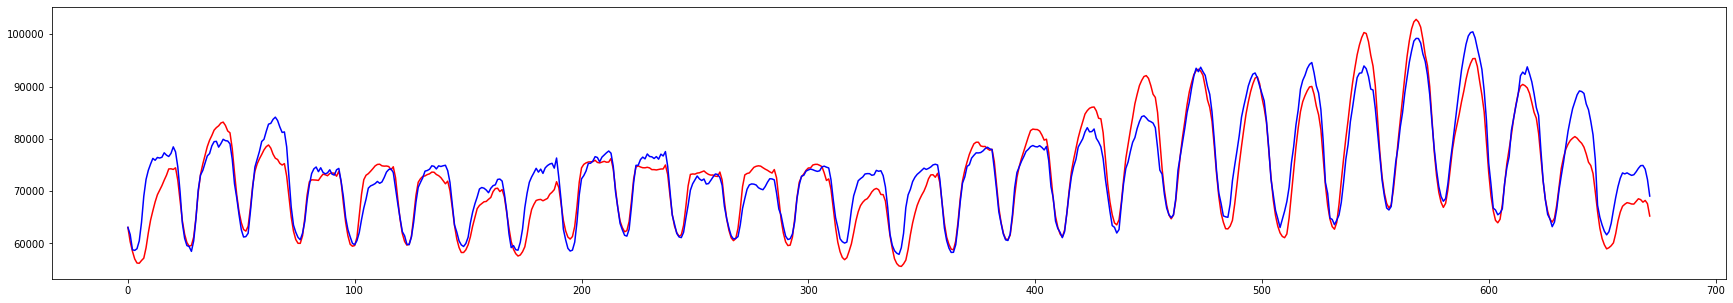

In [32]:
plt.figure(figsize=(30,5))
plt.plot(true, 'r')
plt.plot(pred, 'b')

In [40]:
pd.Series(mape_values).to_csv('5mape.csv')

D:\Ancd\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
